# Introduction
How to open and understand the dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir(r'D:\AI4EO challenge\train_data\train_data')
%matplotlib inline

## Basic information
1. Hyperspectral data:
    1. `hsi_path` contains path to hyperspectral masked numpy arrays containing hyperspectral data that underwent masking (i.e., the field area is masked, whereas all irrelevant areas are not masked)
    2. The name of the file (e.g., _'1989.npz'_) refers to the index of the corresponding training sample in the ground-truth table.
2. Ground-truth data:
    1. `gt_path` contains path to ground truth .csv file.
    2. Additionally, `wavelength_path` contains the mapping between a band number and the corresponding wavelength.


In [2]:
hsi_path = 'train_data/1570.npz'
gt_path = 'train_gt.csv'
wavelength_path = 'wavelengths.csv'

In [3]:
gt_df = pd.read_csv(gt_path)
wavelength_df = pd.read_csv(wavelength_path)

## Ground-truth description
`gt_df` contains:

1. `sample_index` - a reference to the numpay array containing the corresponding hyperspectral data.
2. P (for simplicity, we use P while referring to P_2O_5), K, Mg, pH - soil properties levels based on laboratory measurements.

In [5]:
gt_df[gt_df['sample_index']==1570]


,sample_index,P,K,Mg,pH
1570,1570,47.9,165.0,181.0,6.8


## Displaying one hyperspectral band

band_no       100.00
wavelength    778.54
Name: 99, dtype: float64


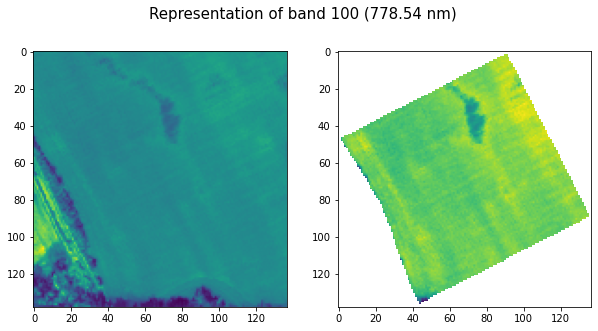

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
band_id = 100
wavelength = wavelength_df.loc[band_id-1]
print(wavelength)
with np.load(hsi_path) as npz:
    arr = np.ma.MaskedArray(**npz)
# arr.shape
axs[0].imshow(arr[band_id,:,:].data)
axs[1].imshow(arr[band_id,:,:])
plt.suptitle(f'Representation of band {int(wavelength["band_no"])} ({wavelength["wavelength"]} nm)', fontsize=15)
plt.show()

<Figure size 432x288 with 0 Axes>

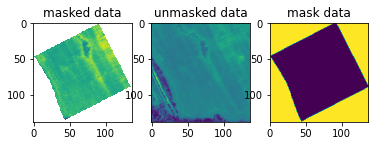

<Figure size 432x288 with 0 Axes>

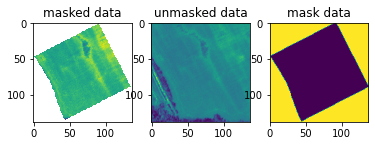

<Figure size 432x288 with 0 Axes>

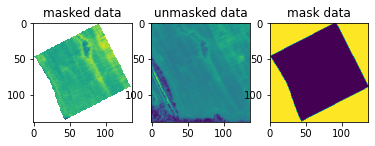

<Figure size 432x288 with 0 Axes>

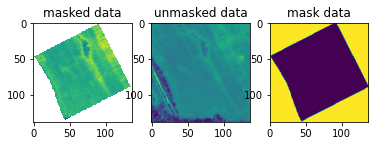

<Figure size 432x288 with 0 Axes>

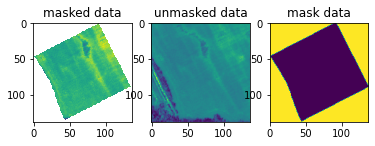

<Figure size 432x288 with 0 Axes>

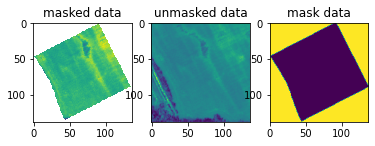

<Figure size 432x288 with 0 Axes>

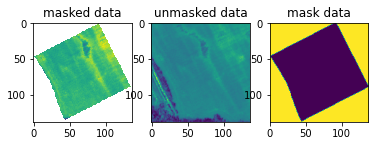

<Figure size 432x288 with 0 Axes>

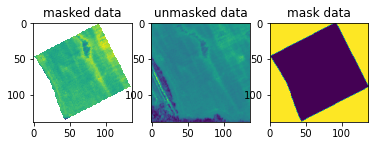

<Figure size 432x288 with 0 Axes>

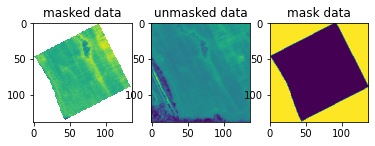

<Figure size 432x288 with 0 Axes>

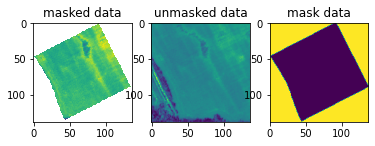

In [8]:
for i in range(10):
    plt.figure()
    fig,(ax1,ax2,ax3)=plt.subplots(1,3)
    ax1.imshow(arr[i,:,:])
    ax1.set_title('masked data')
    ax2.imshow(arr[i,:,:].data)
    ax2.set_title('unmasked data')
    ax3.imshow(arr[i,:,:].mask)
    ax3.set_title('mask data')

## Displaying the aggregated spectral curve for a field

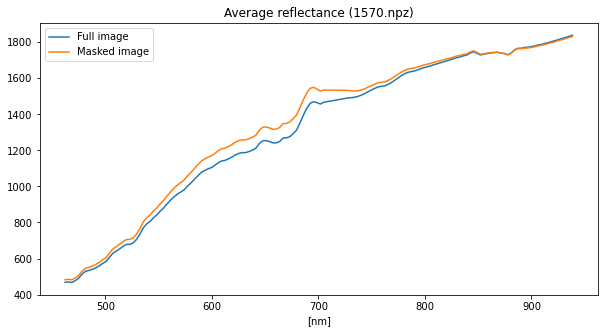

In [7]:
fig = plt.figure(figsize=(10, 5))

masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
full_scene_mean_spectral_reflectance = [arr[i,:,:].data.mean() for i in range(arr.shape[0])]

plt.plot(wavelength_df['wavelength'], full_scene_mean_spectral_reflectance, label='Full image')
plt.plot(wavelength_df['wavelength'], masked_scene_mean_spectral_reflectance, label='Masked image')

plt.xlabel('[nm]')
plt.legend()
plt.title(f'Average reflectance ({hsi_path.split("/")[-1]})')
plt.show()

In [8]:
masked_scene_mean_spectral_reflectance = [arr[i,:,:].mean() for i in range(arr.shape[0])]
len(masked_scene_mean_spectral_reflectance),len(wavelength_df)

(150, 150)

## Notes : there are 150 bands in each image and wavelength_df is indicating a total number of bands

# Generating baseline solution

In [9]:
class BaselineRegressor:
    """
    Baseline regressor, which calculates the mean value of the target from the training
    data and returns it for each testing sample.
    """
    def __init__(self):
        self.mean = 0

    def fit(self, X_train: np.ndarray, y_train: np.ndarray):
        self.mean = np.mean(y_train, axis=0)
        self.classes_count = y_train.shape[1]
        return self

    def predict(self, X_test: np.ndarray):
        return np.full((len(X_test), self.classes_count), self.mean)


class SpectralCurveFiltering():
    """
    Create a histogram (a spectral curve) of a 3D cube, using the merge_function
    to aggregate all pixels within one band. The return array will have
    the shape of [CHANNELS_COUNT]
    """

    def __init__(self, merge_function = np.mean):
        self.merge_function = merge_function

    def __call__(self, sample: np.ndarray):
        return self.merge_function(sample, axis=(1, 2))


## Load the data

In [10]:
import os
from glob import glob

def load_data(directory: str):
    """Load each cube, reduce its dimensionality and append to array.

    Args:
        directory (str): Directory to either train or test set
    Returns:
        [type]: A list with spectral curve for each sample.
    """
    data = []
    filtering = SpectralCurveFiltering()
    all_files = np.array(
        sorted(
            glob(os.path.join(directory, "*.npz")),
            key=lambda x: int(os.path.basename(x).replace(".npz", "")),
        )
    )
    for file_name in all_files:
        with np.load(file_name) as npz:
            arr = np.ma.MaskedArray(**npz)
        arr = filtering(arr)
        data.append(arr)
    return np.array(data)


def load_gt(file_path: str):
    """Load labels for train set from the ground truth file.
    Args:
        file_path (str): Path to the ground truth .csv file.
    Returns:
        [type]: 2D numpy array with soil properties levels
    """
    gt_file = pd.read_csv(file_path)
    labels = gt_file[["P", "K", "Mg", "pH"]].values
    return labels


X_train = load_data("train_data")
y_train = load_gt("train_gt.csv")
X_test = load_data("test_data")

print(f"Train data shape: {X_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Train data y shape:{y_train.shape}")


Train data shape: (1732, 150)
Test data shape: (1154, 150)
Train data y shape:(1732, 4)


In [ ]:
# from sklearn.model_selection import train_test_split
# from sklearn.linear_model import TweedieRegressor

# X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.33, random_state=42)
# print(f'X Train data shape {X_train.shape}')
# print(f'Y Train data shape {y_train.shape}')
# print(f'X Test data shape {X_test.shape}')
# print(f'Y Test data shape {y_test.shape}')

# Sklearn tweedieRegressor Model

In [100]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
# Create linear regression object
regr = linear_model.LinearRegression()
regr.fit(X_train,y_train)


LinearRegression()

In [107]:
# Make predictions using the testing set
y_pred = regr.predict(X_train)
# print(X_test.shape,y_pred.shape)
print(X_train.shape,y_train.shape)



(1732, 150) (1732, 4)


In [108]:

# The coefficients
# print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.2f" % mean_squared_error(y_train, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(y_train, y_pred))



Mean squared error: 1338.24
Coefficient of determination: 0.18


In [124]:
df = pd.DataFrame(y_pred, columns = ["P", "K", "Mg", "pH"])
df.head()

,P,K,Mg,pH
0,44.572126,191.709962,157.180793,6.801048
1,68.068210,197.708301,142.095859,7.032360
2,81.643449,262.694155,152.289097,7.132486
3,68.390017,223.733295,187.627234,6.956670
4,45.427185,216.734583,161.079507,6.753172


In [125]:
gt_df.head()

,sample_index,P,K,Mg,pH
0,0,45.1,188.0,179.0,7.2
1,1,44.8,205.0,188.0,7.0
2,2,44.4,207.0,145.0,6.8
3,3,46.5,204.0,143.0,6.8
4,4,52.0,212.0,167.0,6.7


In [128]:
np.save(r'D:\AI4EO challenge\train_data\train_data\npy data\X_train.npy',X_train)
np.save(r'D:\AI4EO challenge\train_data\train_data\npy data\y_train.npy',y_train)

## Make predictions and generate submission file

In [9]:
baseline_reg = BaselineRegressor()
baseline_reg = baseline_reg.fit(X_train, y_train)
predictions = baseline_reg.predict(X_test)

submission = pd.DataFrame(data = predictions, columns=["P", "K", "Mg", "pH"])
submission.to_csv("submission.csv", index_label="sample_index")


## Calculating the metric

For the purpose of presenting the final metric calculation, we will extract a small _test_set_ from the training set.

In [10]:
X_test = X_train[1500:]
y_test = y_train[1500:]

X_train_new = X_train[:1500]
y_train_new = y_train[:1500]

# Fit the baseline regressor once again on new training set
baseline_reg = baseline_reg.fit(X_train_new, y_train_new)
baseline_predictions = baseline_reg.predict(X_test)

# Generate baseline values to be used in score computation
baselines = np.mean((y_test - baseline_predictions) ** 2, axis=0)


# Generate random predictions, different from baseline predictions
np.random.seed(0)
predictions = np.zeros_like(y_test)
for column_index in range(predictions.shape[1]):
    class_mean_value = baseline_reg.mean[column_index]
    predictions[:, column_index] = np.random.uniform(low=class_mean_value - class_mean_value * 0.05,
                                                     high=class_mean_value + class_mean_value * 0.05,
                                                     size=len(predictions))

# Calculate MSE for each class
mse = np.mean((y_test - predictions) ** 2, axis=0)

# Calculate the score for each class individually
scores = mse / baselines

# Calculate the final score
final_score = np.mean(scores)

for score, class_name in zip(scores, ["P", "K", "Mg", "pH"]):
    print(f"Class {class_name} score: {score}")

print(f"Final score: {final_score}")

Class P score: 0.9896068600445717
Class K score: 1.004900913045855
Class Mg score: 1.0228518828521695
Class pH score: 1.6431314552511207
Final score: 1.1651227777984292
